# Imports

In [6]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Dense, Normalization, Dropout
from keras.optimizers import Adam, SGD
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import FalsePositives

import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import wandb
from wandb.keras import WandbCallback

In [7]:
sweep_config = {
    'method': "bayes",
    'metric': {
        'name': 'loss',
        'goal': 'minimize',
    },
    'parameters': {
        "optimizer": {
            "values": ['adam', 'sgd']
        },
        "nodes": {
            "values": [64, 128, 256, 512, 1024]
        },
        "epochs": {
            'max': 30, 'min': 10
        },
        "learning_rate": {
            'max': 0.01, 'min': 0.00001
        },
        "batch_size": {
            'values': [16, 32, 64]
        },
        "layers": {
            'max': 6, 'min': 1
        },
        'dropout': {
            'values': [0.3, 0.4, 0.5]
        },
    },
}

In [8]:
wandb.login(key="50fdec0adbfaf9ef335c8ec6c0446e412c23a452")
sweep_id = wandb.sweep(sweep_config, project="parodontitis")

wandb: Currently logged in as: tim-avans (krokante-krab). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\izamo/.netrc


Create sweep with ID: ztcfzxmj
Sweep URL: https://wandb.ai/krokante-krab/parodontitis/sweeps/ztcfzxmj


In [9]:
RANDOM_STATE = 1

# Load data

In [10]:
# df = convert_xml_to_dataframe()
df = pd.read_csv('../data/generated/patients-v6.csv')

X = df[[
    # 'PATIENT_ID',
    # 'GENDER_MALE',
    # 'GENDER_FEMALE',
    # 'BIRTH_DATE',
    'AGE_RANGE_20',
    'AGE_RANGE_40',
    'AGE_RANGE_60',
    # 'VISIT_DATE',
    'TREATING_PROVIDER_DENTIST',
    'TREATING_PROVIDER_FACULTY',
    'TREATING_PROVIDER_STUDENT',
    'PROCEDURE_A',
    'PROCEDURE_B',
    'BLEEDING_ON_PROBING',
    'NR_OF_POCKET',
    'NR_OF_FURCATION',
    'NR_OF_MOBILITY',
    'TOTAL_LOSS_OF_ATTACHMENT_LEVEL',
    # 'NOICE_MODIFIED',
    # 'STUDENT_ERROR'
]]

y = df[[
    'HAS_PARODONTITIS'
]]
# df.head()

# Split train and test data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

In [12]:
y_train_without_parodontitis = y_train[y_train["HAS_PARODONTITIS"] == 0]
y_test_without_parodontitis = y_test[y_test["HAS_PARODONTITIS"] == 0]

print(f'y_train: {(100/len(y_train)) * len(y_train_without_parodontitis)}% without parodontitis')
print(f'y_test: {(100/len(y_test)) * len(y_test_without_parodontitis)}% without parodontitis')

y_train: 56.59142857142857% without parodontitis
y_test: 56.593333333333334% without parodontitis


# Normalization

In [13]:
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

# Training

In [14]:
def train():
    default_config={
        "optimizer": 'adam',
        "nodes":128,
        "epochs": 1,
        "learning_rate": 1e-2,
        "batch_size": 32,
        "layers": 2,
        "dropout": 0.4
    }

    wandb.init(config=default_config)
    config = wandb.config

    batch_size = config.batch_size
    epochs = config.epochs
    learning_rate = config.learning_rate
    nodes = config.nodes
    optimizer = config.optimizer
    layers = config.layers
    dropout = config.dropout

    if config.optimizer == 'adam':
        optimizer = Adam(lr=learning_rate)
    elif config.optimizer == 'sgd':
        optimizer = SGD(lr=learning_rate)

    model = Sequential()

    model.add(Input(shape=(X_train.shape[1],)))
    model.add(normalizer)

    for i in range(layers):
        model.add(Dense(nodes, activation='relu'))
        model.add(Dropout(dropout))

    model.add(Dense(2, activation='softmax'))

    model.compile(
        optimizer=optimizer,
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[WandbCallback()], validation_data=(X_test, y_test))
    model.save('models/parodontitis_sparse_categorical_classifier.h5', overwrite=True)
    wandb.log_artifact('models/parodontitis_sparse_categorical_classifier.h5', name='run_' + wandb.run.id + '_model', type='model')

In [15]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: xo5i14by with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 22
wandb: 	layers: 2
wandb: 	learning_rate: 0.0005968591247312209
wandb: 	nodes: 128
wandb: 	optimizer: adam


The `lr` argument is deprecated, use `learning_rate` instead.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/22
1066/1094 [============================>.] - ETA: 0s - loss: 0.1983 - accuracy: 0.8954INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105441-xo5i14by\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105441-xo5i14by\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 3s 2ms/step - loss: 0.1977 - accuracy: 0.8955 - val_loss: 0.1754 - val_accuracy: 0.8993
Epoch 2/22
1064/1094 [============================>.] - ETA: 0s - loss: 0.1787 - accuracy: 0.9007INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105441-xo5i14by\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105441-xo5i14by\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1791 - accuracy: 0.9006 - val_loss: 0.1751 - val_accuracy: 0.9016
Epoch 3/22
1094/1094 [==============================] - 1s 1ms/step - loss: 0.1782 - accuracy: 0.9008 - val_loss: 0.1752 - val_accuracy: 0.9015
Epoch 4/22
1053/1094 [===========================>..] - ETA: 0s - loss: 0.1775 - accuracy: 0.9013INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105441-xo5i14by\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105441-xo5i14by\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1775 - accuracy: 0.9012 - val_loss: 0.1749 - val_accuracy: 0.8986
Epoch 5/22
1090/1094 [============================>.] - ETA: 0s - loss: 0.1770 - accuracy: 0.9015INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105441-xo5i14by\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105441-xo5i14by\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1769 - accuracy: 0.9015 - val_loss: 0.1749 - val_accuracy: 0.9011
Epoch 6/22
1094/1094 [==============================] - 1s 1ms/step - loss: 0.1770 - accuracy: 0.9017 - val_loss: 0.1750 - val_accuracy: 0.9007
Epoch 7/22
1094/1094 [==============================] - 1s 1ms/step - loss: 0.1767 - accuracy: 0.9019 - val_loss: 0.1758 - val_accuracy: 0.9022
Epoch 8/22
1094/1094 [==============================] - 1s 1ms/step - loss: 0.1762 - accuracy: 0.9015 - val_loss: 0.1755 - val_accuracy: 0.8987
Epoch 9/22
1094/1094 [==============================] - 1s 1ms/step - loss: 0.1765 - accuracy: 0.9030 - val_loss: 0.1760 - val_accuracy: 0.8992
Epoch 10/22
1066/1094 [============================>.] - ETA: 0s - loss: 0.1759 - accuracy: 0.9038INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105441-xo5i14by\files\model-best\ass

wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105441-xo5i14by\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1761 - accuracy: 0.9038 - val_loss: 0.1748 - val_accuracy: 0.9000
Epoch 11/22
1049/1094 [===========================>..] - ETA: 0s - loss: 0.1761 - accuracy: 0.9024INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105441-xo5i14by\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105441-xo5i14by\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1760 - accuracy: 0.9025 - val_loss: 0.1748 - val_accuracy: 0.8993
Epoch 12/22
1094/1094 [==============================] - 1s 1ms/step - loss: 0.1757 - accuracy: 0.9038 - val_loss: 0.1759 - val_accuracy: 0.8995
Epoch 13/22
1092/1094 [============================>.] - ETA: 0s - loss: 0.1760 - accuracy: 0.9027INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105441-xo5i14by\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105441-xo5i14by\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1761 - accuracy: 0.9026 - val_loss: 0.1747 - val_accuracy: 0.9003
Epoch 14/22
1094/1094 [==============================] - 2s 1ms/step - loss: 0.1757 - accuracy: 0.9034 - val_loss: 0.1753 - val_accuracy: 0.8985
Epoch 15/22
1094/1094 [==============================] - 1s 1ms/step - loss: 0.1763 - accuracy: 0.9021 - val_loss: 0.1750 - val_accuracy: 0.8992
Epoch 16/22
1094/1094 [==============================] - 1s 1ms/step - loss: 0.1756 - accuracy: 0.9037 - val_loss: 0.1752 - val_accuracy: 0.9008
Epoch 17/22
1094/1094 [==============================] - 2s 1ms/step - loss: 0.1759 - accuracy: 0.9034 - val_loss: 0.1750 - val_accuracy: 0.9002
Epoch 18/22
1094/1094 [==============================] - 2s 1ms/step - loss: 0.1755 - accuracy: 0.9031 - val_loss: 0.1750 - val_accuracy: 0.8987
Epoch 19/22
1094/1094 [==============================] - 1s 1ms/step - loss: 0.1756 - accuracy: 0.9032 - val_loss: 0.1748 - val_accuracy: 0.90

accuracy,▁▅▅▆▆▆▆▆▇█▇█▇█▆██▇▇▇▇█
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▇▇▂▆▅█▂▃▄▃▃▅▁▃▆▄▂▅▃▁▆
val_loss,▅▃▃▂▂▃▇▅█▁▁█▁▄▂▄▂▂▁▄▅▂
accuracy,0.90396
best_epoch,12
best_val_loss,0.17473
epoch,21
loss,0.17503
val_accuracy,0.9013


wandb: Agent Starting Run: jhg6mx6c with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 13
wandb: 	layers: 4
wandb: 	learning_rate: 0.002187309101014645
wandb: 	nodes: 128
wandb: 	optimizer: sgd


Epoch 1/13


The `lr` argument is deprecated, use `learning_rate` instead.


2153/2188 [============================>.] - ETA: 0s - loss: 0.4064 - accuracy: 0.8138INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 4s 2ms/step - loss: 0.4038 - accuracy: 0.8152 - val_loss: 0.2132 - val_accuracy: 0.8973
Epoch 2/13
2182/2188 [============================>.] - ETA: 0s - loss: 0.2271 - accuracy: 0.8964INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 4s 2ms/step - loss: 0.2272 - accuracy: 0.8964 - val_loss: 0.1849 - val_accuracy: 0.8992
Epoch 3/13
2155/2188 [============================>.] - ETA: 0s - loss: 0.2061 - accuracy: 0.8974INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 4s 2ms/step - loss: 0.2061 - accuracy: 0.8973 - val_loss: 0.1794 - val_accuracy: 0.8995
Epoch 4/13
2182/2188 [============================>.] - ETA: 0s - loss: 0.1977 - accuracy: 0.8989INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 4s 2ms/step - loss: 0.1978 - accuracy: 0.8989 - val_loss: 0.1781 - val_accuracy: 0.8978
Epoch 5/13
2177/2188 [============================>.] - ETA: 0s - loss: 0.1936 - accuracy: 0.8983INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 4s 2ms/step - loss: 0.1935 - accuracy: 0.8984 - val_loss: 0.1774 - val_accuracy: 0.8971
Epoch 6/13
2149/2188 [============================>.] - ETA: 0s - loss: 0.1892 - accuracy: 0.8993INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 4s 2ms/step - loss: 0.1893 - accuracy: 0.8992 - val_loss: 0.1772 - val_accuracy: 0.8970
Epoch 7/13
2152/2188 [============================>.] - ETA: 0s - loss: 0.1887 - accuracy: 0.8997INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 3s 2ms/step - loss: 0.1886 - accuracy: 0.8994 - val_loss: 0.1767 - val_accuracy: 0.8971
Epoch 8/13
2177/2188 [============================>.] - ETA: 0s - loss: 0.1878 - accuracy: 0.8988INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 4s 2ms/step - loss: 0.1877 - accuracy: 0.8988 - val_loss: 0.1765 - val_accuracy: 0.8977
Epoch 9/13
2188/2188 [==============================] - 3s 1ms/step - loss: 0.1869 - accuracy: 0.8987 - val_loss: 0.1767 - val_accuracy: 0.8973
Epoch 10/13
2156/2188 [============================>.] - ETA: 0s - loss: 0.1867 - accuracy: 0.8988INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 4s 2ms/step - loss: 0.1866 - accuracy: 0.8988 - val_loss: 0.1761 - val_accuracy: 0.8973
Epoch 11/13
2153/2188 [============================>.] - ETA: 0s - loss: 0.1865 - accuracy: 0.8981INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 4s 2ms/step - loss: 0.1866 - accuracy: 0.8984 - val_loss: 0.1759 - val_accuracy: 0.8971
Epoch 12/13
2188/2188 [==============================] - 3s 1ms/step - loss: 0.1844 - accuracy: 0.8998 - val_loss: 0.1761 - val_accuracy: 0.8969
Epoch 13/13
2159/2188 [============================>.] - ETA: 0s - loss: 0.1849 - accuracy: 0.8998INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105534-jhg6mx6c\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 4s 2ms/step - loss: 0.1845 - accuracy: 0.8999 - val_loss: 0.1759 - val_accuracy: 0.8970


accuracy,▁████████████
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▇█▄▂▁▂▃▂▂▂▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁
accuracy,0.89994
best_epoch,12
best_val_loss,0.17585
epoch,12
loss,0.1845
val_accuracy,0.89697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9ub69t2r with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	layers: 2
wandb: 	learning_rate: 0.004859339632217407
wandb: 	nodes: 64
wandb: 	optimizer: sgd


Epoch 1/30


The `lr` argument is deprecated, use `learning_rate` instead.


1067/1094 [============================>.] - ETA: 0s - loss: 0.3609 - accuracy: 0.8349INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.3580 - accuracy: 0.8364 - val_loss: 0.2051 - val_accuracy: 0.8978
Epoch 2/30
1056/1094 [===========================>..] - ETA: 0s - loss: 0.2257 - accuracy: 0.8955INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 1ms/step - loss: 0.2256 - accuracy: 0.8953 - val_loss: 0.1861 - val_accuracy: 0.9001
Epoch 3/30
1065/1094 [============================>.] - ETA: 0s - loss: 0.2076 - accuracy: 0.8977INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 1ms/step - loss: 0.2074 - accuracy: 0.8978 - val_loss: 0.1817 - val_accuracy: 0.8998
Epoch 4/30
1085/1094 [============================>.] - ETA: 0s - loss: 0.1997 - accuracy: 0.8986INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1995 - accuracy: 0.8987 - val_loss: 0.1800 - val_accuracy: 0.8997
Epoch 5/30
1043/1094 [===========================>..] - ETA: 0s - loss: 0.1951 - accuracy: 0.8997INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1952 - accuracy: 0.8996 - val_loss: 0.1786 - val_accuracy: 0.8990
Epoch 6/30
1031/1094 [===========================>..] - ETA: 0s - loss: 0.1931 - accuracy: 0.8995INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1934 - accuracy: 0.8994 - val_loss: 0.1779 - val_accuracy: 0.8991
Epoch 7/30
1090/1094 [============================>.] - ETA: 0s - loss: 0.1910 - accuracy: 0.8989INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1911 - accuracy: 0.8989 - val_loss: 0.1777 - val_accuracy: 0.8992
Epoch 8/30
1045/1094 [===========================>..] - ETA: 0s - loss: 0.1892 - accuracy: 0.8985INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1897 - accuracy: 0.8986 - val_loss: 0.1769 - val_accuracy: 0.8993
Epoch 9/30
1087/1094 [============================>.] - ETA: 0s - loss: 0.1875 - accuracy: 0.8996INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1875 - accuracy: 0.8997 - val_loss: 0.1768 - val_accuracy: 0.8998
Epoch 10/30
1039/1094 [===========================>..] - ETA: 0s - loss: 0.1874 - accuracy: 0.8999INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 1ms/step - loss: 0.1881 - accuracy: 0.8999 - val_loss: 0.1764 - val_accuracy: 0.9000
Epoch 11/30
1042/1094 [===========================>..] - ETA: 0s - loss: 0.1857 - accuracy: 0.8985INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 1ms/step - loss: 0.1854 - accuracy: 0.8986 - val_loss: 0.1762 - val_accuracy: 0.8997
Epoch 12/30
1066/1094 [============================>.] - ETA: 0s - loss: 0.1861 - accuracy: 0.8991INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1861 - accuracy: 0.8988 - val_loss: 0.1762 - val_accuracy: 0.8994
Epoch 13/30
1045/1094 [===========================>..] - ETA: 0s - loss: 0.1853 - accuracy: 0.8982INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 1ms/step - loss: 0.1855 - accuracy: 0.8979 - val_loss: 0.1760 - val_accuracy: 0.8992
Epoch 14/30
1053/1094 [===========================>..] - ETA: 0s - loss: 0.1849 - accuracy: 0.9007INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 1ms/step - loss: 0.1852 - accuracy: 0.9005 - val_loss: 0.1758 - val_accuracy: 0.8994
Epoch 15/30
1043/1094 [===========================>..] - ETA: 0s - loss: 0.1841 - accuracy: 0.8991INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1843 - accuracy: 0.8989 - val_loss: 0.1756 - val_accuracy: 0.8999
Epoch 16/30
1036/1094 [===========================>..] - ETA: 0s - loss: 0.1852 - accuracy: 0.8996INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1853 - accuracy: 0.8995 - val_loss: 0.1756 - val_accuracy: 0.9002
Epoch 17/30
1054/1094 [===========================>..] - ETA: 0s - loss: 0.1839 - accuracy: 0.8992INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 1ms/step - loss: 0.1836 - accuracy: 0.8994 - val_loss: 0.1756 - val_accuracy: 0.8999
Epoch 18/30
1094/1094 [==============================] - 1s 992us/step - loss: 0.1835 - accuracy: 0.8995 - val_loss: 0.1757 - val_accuracy: 0.8996
Epoch 19/30
1040/1094 [===========================>..] - ETA: 0s - loss: 0.1828 - accuracy: 0.8983INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 3s 2ms/step - loss: 0.1826 - accuracy: 0.8983 - val_loss: 0.1755 - val_accuracy: 0.9000
Epoch 20/30
1044/1094 [===========================>..] - ETA: 0s - loss: 0.1829 - accuracy: 0.8986INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1831 - accuracy: 0.8985 - val_loss: 0.1753 - val_accuracy: 0.8997
Epoch 21/30
1063/1094 [============================>.] - ETA: 0s - loss: 0.1827 - accuracy: 0.8988INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 1ms/step - loss: 0.1828 - accuracy: 0.8986 - val_loss: 0.1753 - val_accuracy: 0.8997
Epoch 22/30
1094/1094 [==============================] - 1s 969us/step - loss: 0.1822 - accuracy: 0.8985 - val_loss: 0.1753 - val_accuracy: 0.8991
Epoch 23/30
1094/1094 [==============================] - 1s 962us/step - loss: 0.1818 - accuracy: 0.8992 - val_loss: 0.1753 - val_accuracy: 0.8993
Epoch 24/30
1052/1094 [===========================>..] - ETA: 0s - loss: 0.1822 - accuracy: 0.9005INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1821 - accuracy: 0.9007 - val_loss: 0.1752 - val_accuracy: 0.8992
Epoch 25/30
1094/1094 [==============================] - 1s 1ms/step - loss: 0.1812 - accuracy: 0.8998 - val_loss: 0.1752 - val_accuracy: 0.8994
Epoch 26/30
1094/1094 [==============================] - 1s 978us/step - loss: 0.1813 - accuracy: 0.9000 - val_loss: 0.1752 - val_accuracy: 0.8995
Epoch 27/30
1094/1094 [==============================] - 1s 955us/step - loss: 0.1814 - accuracy: 0.8990 - val_loss: 0.1752 - val_accuracy: 0.8995
Epoch 28/30
1094/1094 [==============================] - 1s 965us/step - loss: 0.1807 - accuracy: 0.8996 - val_loss: 0.1753 - val_accuracy: 0.8991
Epoch 29/30
1063/1094 [============================>.] - ETA: 0s - loss: 0.1813 - accuracy: 0.8994INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\mode

wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105650-9ub69t2r\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 2s 2ms/step - loss: 0.1810 - accuracy: 0.8995 - val_loss: 0.1751 - val_accuracy: 0.8990
Epoch 30/30
1094/1094 [==============================] - 1s 1ms/step - loss: 0.1813 - accuracy: 0.8994 - val_loss: 0.1751 - val_accuracy: 0.8992


accuracy,▁▇████████████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁█▇▆▅▅▅▅▇▇▇▆▅▆▇█▇▆▇▆▇▅▅▅▆▆▆▅▄▅
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.89937
best_epoch,28
best_val_loss,0.17512
epoch,29
loss,0.18126
val_accuracy,0.89923


wandb: Agent Starting Run: fjtfp7lr with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 23
wandb: 	layers: 4
wandb: 	learning_rate: 0.007847750026726859
wandb: 	nodes: 256
wandb: 	optimizer: adam


Epoch 1/23


The `lr` argument is deprecated, use `learning_rate` instead.


1082/1094 [============================>.] - ETA: 0s - loss: 0.1964 - accuracy: 0.8972INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105748-fjtfp7lr\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105748-fjtfp7lr\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 5s 4ms/step - loss: 0.1966 - accuracy: 0.8971 - val_loss: 0.1774 - val_accuracy: 0.9016
Epoch 2/23
1083/1094 [============================>.] - ETA: 0s - loss: 0.2042 - accuracy: 0.8981INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105748-fjtfp7lr\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105748-fjtfp7lr\files\model-best)... Done. 0.0s


1094/1094 [==============================] - 5s 5ms/step - loss: 0.2041 - accuracy: 0.8981 - val_loss: 0.1746 - val_accuracy: 0.9016
Epoch 3/23
1094/1094 [==============================] - 3s 3ms/step - loss: 0.1793 - accuracy: 0.9027 - val_loss: 0.1764 - val_accuracy: 0.9016
Epoch 4/23
1094/1094 [==============================] - 3s 3ms/step - loss: 0.1871 - accuracy: 0.8992 - val_loss: 0.1776 - val_accuracy: 0.9016
Epoch 5/23
1094/1094 [==============================] - 3s 3ms/step - loss: 0.1955 - accuracy: 0.8990 - val_loss: 0.1756 - val_accuracy: 0.9016
Epoch 6/23
1094/1094 [==============================] - 3s 3ms/step - loss: 0.1843 - accuracy: 0.9000 - val_loss: 0.1751 - val_accuracy: 0.8972
Epoch 7/23
1094/1094 [==============================] - 3s 3ms/step - loss: 0.1909 - accuracy: 0.8996 - val_loss: 0.1759 - val_accuracy: 0.9014
Epoch 8/23
1094/1094 [==============================] - 3s 3ms/step - loss: 0.1837 - accuracy: 0.9015 - val_loss: 0.1750 - val_accuracy: 0.9016
Epo

wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105748-fjtfp7lr\files\model-best)... Done. 0.0s
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


1094/1094 [==============================] - 14s 13ms/step - loss: 0.2435 - accuracy: 0.8979 - val_loss: 0.1746 - val_accuracy: 0.9016
Epoch 14/23
1094/1094 [==============================] - 3s 3ms/step - loss: 0.1960 - accuracy: 0.8969 - val_loss: 0.1765 - val_accuracy: 0.8972
Epoch 15/23
1094/1094 [==============================] - 3s 3ms/step - loss: 0.2074 - accuracy: 0.8974 - val_loss: 0.1751 - val_accuracy: 0.8972
Epoch 16/23
1094/1094 [==============================] - 3s 3ms/step - loss: 0.1971 - accuracy: 0.8990 - val_loss: 0.1750 - val_accuracy: 0.9016
Epoch 17/23
1094/1094 [==============================] - 3s 3ms/step - loss: 0.1977 - accuracy: 0.8989 - val_loss: 0.1748 - val_accuracy: 0.8972
Epoch 18/23
1094/1094 [==============================] - 3s 3ms/step - loss: 0.1874 - accuracy: 0.8998 - val_loss: 0.1748 - val_accuracy: 0.8972
Epoch 19/23
1094/1094 [==============================] - 3s 3ms/step - loss: 0.1830 - accuracy: 0.8997 - val_loss: 0.1755 - val_accuracy: 0.

accuracy,▁▂█▄▃▅▄▇▅▅▆▅▂▁▂▄▃▄▄▅▅▄▅
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,▃▄▁▂▃▂▂▁▃▅▂▃█▃▄▃▃▂▁▂▂▅▅
val_accuracy,█████▁█████▁█▁▁█▁▁█▁▁▁▁
val_loss,▅▁▄▅▂▂▃▂▅▂▂▂▁▄▂▂▁▁▂▂▁█▁
accuracy,0.89984
best_epoch,12
best_val_loss,0.1746
epoch,22
loss,0.2163
val_accuracy,0.89723


wandb: Agent Starting Run: y2tonv83 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 11
wandb: 	layers: 5
wandb: 	learning_rate: 0.002157671593676948
wandb: 	nodes: 128
wandb: 	optimizer: sgd


Epoch 1/11


The `lr` argument is deprecated, use `learning_rate` instead.


2150/2188 [============================>.] - ETA: 0s - loss: 0.5428 - accuracy: 0.7301INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105927-y2tonv83\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105927-y2tonv83\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 5s 2ms/step - loss: 0.5394 - accuracy: 0.7323 - val_loss: 0.2486 - val_accuracy: 0.8974
Epoch 2/11
2153/2188 [============================>.] - ETA: 0s - loss: 0.2893 - accuracy: 0.8799INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105927-y2tonv83\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105927-y2tonv83\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 4s 2ms/step - loss: 0.2887 - accuracy: 0.8801 - val_loss: 0.1950 - val_accuracy: 0.8987
Epoch 3/11
2154/2188 [============================>.] - ETA: 0s - loss: 0.2402 - accuracy: 0.8924INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105927-y2tonv83\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105927-y2tonv83\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 4s 2ms/step - loss: 0.2406 - accuracy: 0.8922 - val_loss: 0.1830 - val_accuracy: 0.8997
Epoch 4/11
2186/2188 [============================>.] - ETA: 0s - loss: 0.2207 - accuracy: 0.8960INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105927-y2tonv83\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105927-y2tonv83\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 4s 2ms/step - loss: 0.2208 - accuracy: 0.8959 - val_loss: 0.1792 - val_accuracy: 0.9008
Epoch 5/11
2166/2188 [============================>.] - ETA: 0s - loss: 0.2119 - accuracy: 0.8956INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105927-y2tonv83\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105927-y2tonv83\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 5s 2ms/step - loss: 0.2114 - accuracy: 0.8959 - val_loss: 0.1777 - val_accuracy: 0.9013
Epoch 6/11
2186/2188 [============================>.] - ETA: 0s - loss: 0.2039 - accuracy: 0.8980INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105927-y2tonv83\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105927-y2tonv83\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 4s 2ms/step - loss: 0.2039 - accuracy: 0.8979 - val_loss: 0.1769 - val_accuracy: 0.9018
Epoch 7/11
2172/2188 [============================>.] - ETA: 0s - loss: 0.2000 - accuracy: 0.8981INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105927-y2tonv83\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105927-y2tonv83\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 4s 2ms/step - loss: 0.2002 - accuracy: 0.8981 - val_loss: 0.1767 - val_accuracy: 0.9008
Epoch 8/11
2169/2188 [============================>.] - ETA: 0s - loss: 0.1976 - accuracy: 0.8985INFO:tensorflow:Assets written to: C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105927-y2tonv83\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\izamo\Documenten (2)\1-Documenten\Avans\Jaar 4\Minor\AI-Project\Parodontitis\python\notebooks\wandb\run-20221215_105927-y2tonv83\files\model-best)... Done. 0.0s


2188/2188 [==============================] - 4s 2ms/step - loss: 0.1977 - accuracy: 0.8986 - val_loss: 0.1764 - val_accuracy: 0.9010
Epoch 9/11
2188/2188 [==============================] - 3s 2ms/step - loss: 0.1960 - accuracy: 0.8984 - val_loss: 0.1767 - val_accuracy: 0.9009
Epoch 10/11
2188/2188 [==============================] - 4s 2ms/step - loss: 0.1936 - accuracy: 0.8978 - val_loss: 0.1769 - val_accuracy: 0.9014
Epoch 11/11
2188/2188 [==============================] - 3s 2ms/step - loss: 0.1942 - accuracy: 0.8981 - val_loss: 0.1771 - val_accuracy: 0.9015


accuracy,▁▇█████████
epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▃▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▇█▆▇▇▇█
val_loss,█▃▂▁▁▁▁▁▁▁▁
accuracy,0.89814
best_epoch,7
best_val_loss,0.17636
epoch,10
loss,0.19417
val_accuracy,0.9015


# Saving the model

In [16]:
# Download your Model Version files
# wandb.init()
# path = wandb.use_artifact('parodontitis/run_9c859hs6_model:v0').download()

# Reconstruct your model object in memory:
# `make_model_from_data` below represents your deserialization logic
# to load in a model from disk
from keras.models import load_model
model = load_model('models/parodontitis_sparse_categorical_classifier.h5')

## Validation using the test set

In [17]:
result = model.predict(X_test)
result = pd.DataFrame(result)

print(result)
result['PREDICTION'] = result.apply(lambda x: 0 if x.loc[0] > x.loc[1] else 1, axis=1)

y_test = y_test.reset_index()
y_test['PREDICTION'] = result['PREDICTION']

validation_result = y_test[['PREDICTION', 'HAS_PARODONTITIS']]

938/938 [==============================] - 1s 636us/step
              0             1
0      0.029237  9.707628e-01
1      1.000000  1.336303e-08
2      0.999999  7.929987e-07
3      0.999994  6.087066e-06
4      0.522942  4.770582e-01
...         ...           ...
29995  0.025811  9.741886e-01
29996  0.527084  4.729156e-01
29997  1.000000  5.913245e-08
29998  0.088180  9.118198e-01
29999  0.032574  9.674259e-01

[30000 rows x 2 columns]


In [18]:
wrong_prediction = validation_result[validation_result["HAS_PARODONTITIS"] != validation_result['PREDICTION']]
print(f"Predicted wrong: {len(wrong_prediction)}/{len(validation_result)}")

Predicted wrong: 2955/30000


# SHAP

In [19]:
shap.initjs()

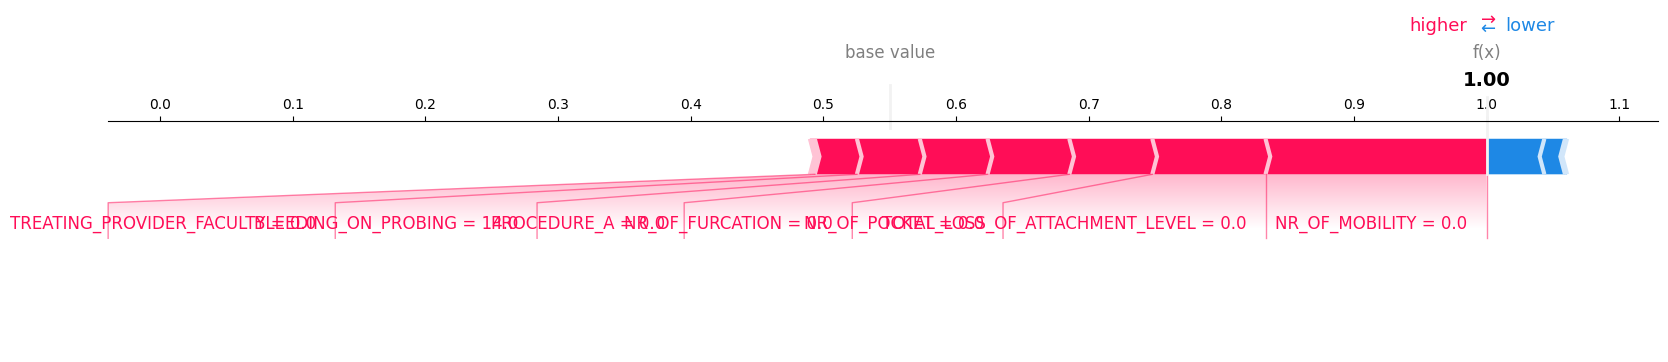

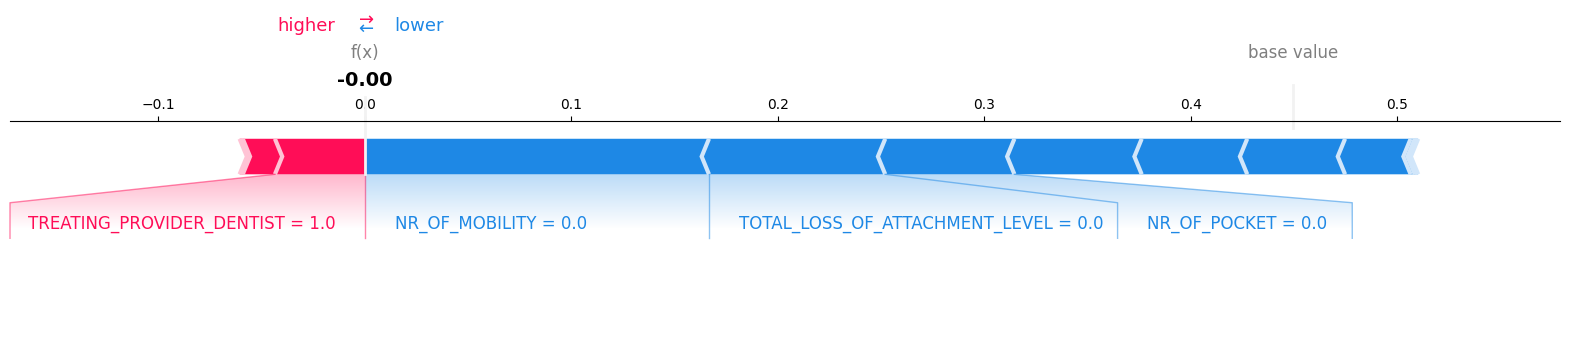

In [20]:
shap_explainer = shap.KernelExplainer(model, X_train[:100])

sample = np.array(X_train.iloc[1])
# sample = np.array([2,2,0,0,1]) # <- playable sample

shap_values = shap_explainer.shap_values(sample)

# Label: has not parodontitis
shap.force_plot(
    shap_explainer.expected_value[0], shap_values[0], sample, matplotlib=True, show=False, plot_cmap=['#77dd77', '#f99191'], feature_names=X_train.columns
)

# Label: has parodontitis
shap.force_plot(
    shap_explainer.expected_value[1], shap_values[1], sample, matplotlib=True, show=False, plot_cmap=['#77dd77', '#f99191'], feature_names=X_train.columns
)

plt.show()